**NOTICE**

Many of the datapaths are pointing to local directories at "Downloads/FinalProject483/". If you wish to run it on your local device the paths will need to be changed.

There are portions of the code that only need to be ran once, or none at all. These locations are marked and labeled.



In [1]:
%conda install conda-forge::tensorflow

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed

Note: you may need to restart the kernel to use updated packages.



Examining conda-forge::tensorflow: 100%|##########| 5/5 [00:01<00:00,  4.70it/s]
                                                                                

Examining conflict for python tensorflow:   0%|          | 0/5 [00:00<?, ?it/s]
                                                                               

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - conda-forge::tensorflow -> python[version='3.5.*|3.6.*|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0']

Your python: python=3.9

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.





In [4]:
!pip install pandas==2.1.4 --user

  Using cached pandas-2.1.4-cp39-cp39-win_amd64.whl (10.8 MB)


Import list (I don't know if all are used)

In [1]:
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from collections import defaultdict
from shutil import copy, copytree, rmtree
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50V2
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import seaborn as sns
import tkinter as tk
from tkinter import *
from tkinter.ttk import *
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import math

Loading the .json file that indicates which images to sort into train and test

In [5]:
train_file = json.loads(open("Downloads/FinalProject483/meta/meta/train.json").read())
test_file = json.loads(open("Downloads/FinalProject483/meta/meta/test.json").read())

Additional function that helps to sort images into proper folders

In [52]:
def types(file):
    all_types = []
    for line in file:
        all_types.append(line)
        
    return all_types

#print(train_file["apple_pie"])
def instance(file):
    for files in file["apple_pie"]:
        print(files)
        
        
all_train_types = types(train_file)
all_test_types = types(test_file)
#instance()

In [53]:
print(all_test_types[0:5])

['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop']


**RUN ONCE**

Function to sort the proper images into train and test folders. In this instance, I made a subset of the training and test data to make the project more feasible to run. Once finished doesn't need to be ran more than once since it saves to a folder

In [24]:
#Only needs to run once per machine

def setup_data(file, source, destination, foods):
    food_types = defaultdict(list) #Makes a variable list
    for line in file: #For every "line" in "file.json" there should be a header for each of the file names. The headers are stored in "line"
        for food_type in file[line]: #Then looks through each of the corresponding file names in the file per the headers. Each of the files get called by food_type
            food_def = food_type.split("/") #All of the file names are in "header"/1234 (number) format. ALl of the files themselves are numbers 
            if food_def[0] in foods: #Food_def[0] and line are functionally the same, as they are both the headers. Makes sure that the food type is in the variable "foods", in case we want to limit the foods
                food_types[food_def[0]].append(food_def[1]+".jpg") #Formats food_types to be the same as the json file, with the file names appending to the headers. These files currently have no data, only points at what we want to find later
    
    for food in food_types.keys(): #.keys() refers to the headers. Once again, we look through the headers
        
        if not os.path.exists(os.path.join(destination, food)): #If the corresponding folder does not exist yet,
            os.makedirs(os.path.join(destination, food)) #Make the folder. Food refers to the folder name, which should correspond to the header
        for n in food_types[food]: #And now for every file name we have,
            copy(os.path.join(source, food, n), os.path.join(destination, food, n)) #Copy the file from the original folder into the new folder.
        print("Created", food, " folder, ") #Lets us know what part of the process we are on. ~Took 30 minutes on my machine
    
    print("Done")
    print("\n")
        
setup_data(train_file, 'Downloads/FinalProject483/images', 'Downloads/FinalProject483/train_subset', all_train_types[0:5])
setup_data(test_file, 'Downloads/FinalProject483/images', 'Downloads/FinalProject483/test_subset', all_test_types[0:5])

Created churros  folder, 
Created hot_and_sour_soup  folder, 
Created samosa  folder, 
Created sashimi  folder, 
Created pork_chop  folder, 
Done


Created churros  folder, 
Created hot_and_sour_soup  folder, 
Created samosa  folder, 
Created sashimi  folder, 
Created pork_chop  folder, 
Done




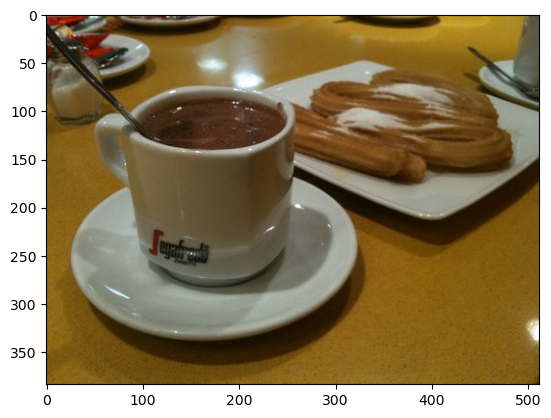

In [16]:
img = mpimg.imread("Downloads/FinalProject483/train_subset/churros/27769.jpg")
plt.imshow(img)
plt.show()

A lot of iterations were performed before this point, so some lines are residuals from past iterations that I kept some part of. This block of code was mainly used for the class_names variable

In [54]:
image_size = (256, 256)
img_height = image_size[0]
img_width = image_size[1]

data_gen = ImageDataGenerator(rotation_range=30, rescale=1./255, validation_split=0.2)
train_gen = data_gen.flow_from_directory('Downloads/FinalProject483/train_subset', target_size=image_size) # default mode categorical
test_gen = data_gen.flow_from_directory('Downloads/FinalProject483/train_subset', target_size=image_size) # default batch_size is 32
class_names = list(train_gen.class_indices.keys())

Found 3750 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.


Start of Final model used

In [ ]:
# Set paths to proper directories
train_dir = 'Downloads/FinalProject483/train_subset'
test_dir = 'Downloads/FinalProject483/test_subset'

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=12345,
    image_size=image_size,
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=12345,
    image_size=image_size,
    batch_size=32,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=32,
    label_mode='categorical'
)

**RUN ONCE**

This line does not need to be ran more than once, it also does not need to be ran if you download the model files

In [ ]:
base_model = MobileNetV2(input_shape=(256, 256, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'), #Only Use one layer
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True) #Used early stopping at first, but found out the model is better off running full
checkpoint = ModelCheckpoint(filepath='Downloads\FinalProject483\model_test.weights.h5', verbose=1, save_best_only=True, save_weights_only=True) #ALlows the model to only improve (most of the time)

with open('Downloads\FinalProject483\model_model.pkl', 'wb') as f:
    pickle.dump(model, f)

**RUN ONCE**

This line does not need to be ran more than once, it also does not need to be ran if you download the model files

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=1, callbacks=[checkpoint])

with open('Downloads\FinalProject483\model_history.pkl', 'wb') as f:
    pickle.dump(history, f)

Creates the accuracy and loss graph

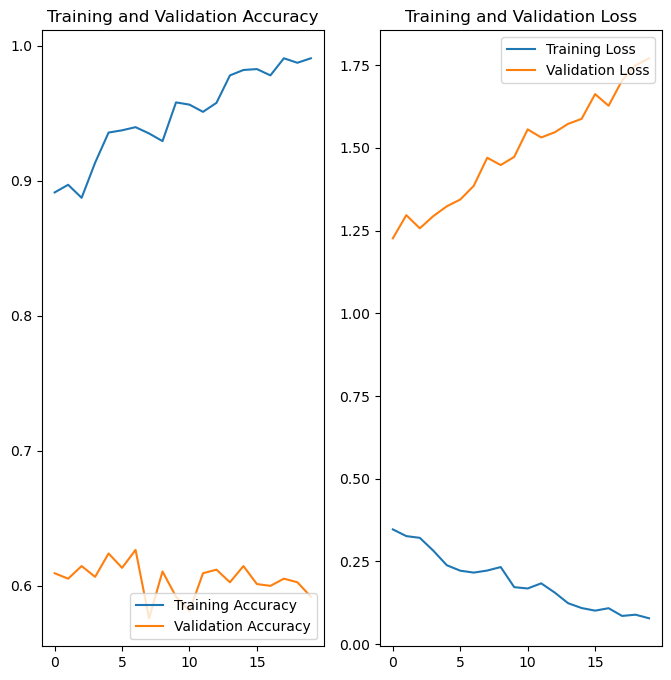

In [57]:
with open('Downloads\FinalProject483\model_history.pkl', 'rb') as f:
    history = pickle.load(f)
    
with open('Downloads\FinalProject483\model_model.pkl', 'rb') as f:
    model = pickle.load(f)

epochs = 20

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image prediction function that uses the model.

In [87]:
def image_prediction(filename, img_height, img_width, class_names, model):
    img = tf.keras.utils.load_img(
        filename, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return class_names, score

Calculates a confusion matrix to visualize predictions easier

In [88]:
true_type = []
pred_type = []
labels = []

for food_type in os.listdir('Downloads/FinalProject483/test_subset'):
    labels.append(food_type)
    for file in os.listdir(f'Downloads/FinalProject483/test_subset/{food_type}'):
        img = tf.keras.utils.load_img(f'Downloads/FinalProject483/test_subset/{food_type}/{file}', target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        true_type.append(food_type)
        pred_type.append(class_names[np.argmax(score)])
        
    print(f"{food_type} folder finished")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
churros folder finished
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

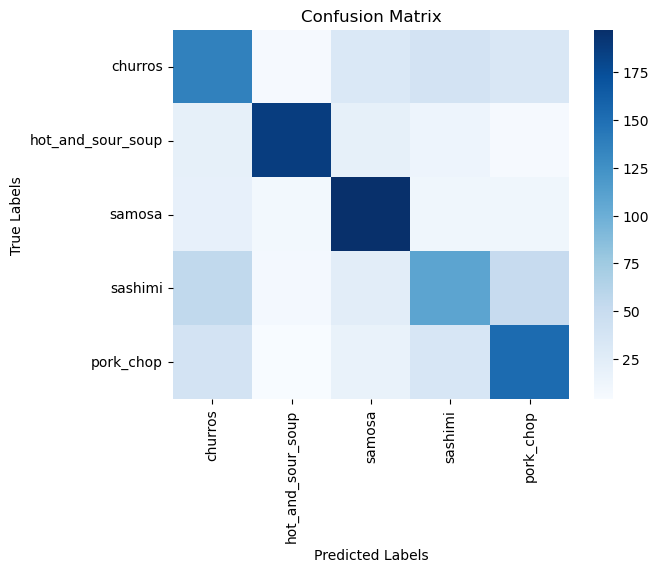

In [103]:
cm = confusion_matrix(true_type, pred_type, labels=labels)

sns.heatmap(cm, cmap='Blues',
           xticklabels=['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop'],
           yticklabels=['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

All of the defining functions for the application to work

In [2]:
def image_prediction(filename, img_height, img_width, class_names, model):
    img = tf.keras.utils.load_img(
        filename, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return class_names, score

def find_nutrition(food, entry):
    food_types = ['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop']
    energy = [985.0, 318.0, 932.0, 670.0, 953.5] #kJ
    fat = [8.7, 2.22, 10.0, 4.3, 16.3] #g
    sat_fat = [1.3, 0.66, 1.8, 0.5, 6.01] #g
    carb = [33.7, 9.6, 24.9, 4.0, 0.0] #g
    sugar = [5.2, 2.0, 3.3, 0.0, 0.0] #g
    protein = [4.9, 2.66, 7.1, 5.5, 18.9] #g
    salt = [0.96, 1.14, 1.05, 0.3, 2.03] #g
    fiber = [2.25, 1.2, 2.55, 1.0, 0.0] #g
    
    if food in food_types:
        index = food_types.index(food)
        
        cache_data = [energy[index] * entry, fat[index] * entry, sat_fat[index] * entry, carb[index] * entry, sugar[index] * entry, protein[index] * entry, salt[index] * entry, fiber[index] * entry]
        
        with open('Downloads/FinalProject483/temp_cache.json', 'w') as file:
            json.dump(cache_data, file)
            print("temp_cache written")
        
        return energy[index] * entry, fat[index] * entry, sat_fat[index] * entry, carb[index] * entry, sugar[index] * entry, protein[index] * entry, salt[index] * entry, fiber[index] * entry
        
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 

def find_percentage(food, entry):
    energy, fat, sat_fat, carb, sugar, protein, salt, fiber = find_nutrition(food, entry)
    requirements = [8700, 78, 20, 275, 30, 50, 23, 28]
    types = ['energy', 'fat', 'sat_fat', 'carb', 'sugar', 'protein', 'salt', 'fiber']
    intake = [energy, fat, sat_fat, carb, sugar, protein, salt, fiber]
    intake_per = []
    output = []
    
    intake_per.append((energy / 8700) * 100)
    intake_per.append((fat / 78) * 100)
    intake_per.append((sat_fat / 20) * 100)
    intake_per.append((carb / 275) * 100)
    intake_per.append((sugar / 30) * 100)
    intake_per.append((protein / 50) * 100)
    intake_per.append((salt / 23) * 100)
    intake_per.append((fiber / 28) * 100)
    
    for rq in intake_per:

        if (intake_per.index(rq) == 0): #For energy only
            output.append("The {} {} offers {}kJ of {}, which is {}% of your daily requirement of {}kJ".format(entry, food,
                                                                                              round(intake[intake_per.index(rq)], 3),
                                                                                                types[intake_per.index(rq)],
                                                                                                round(rq, 2),
                                                                                                 requirements[intake_per.index(rq)]))
        else:
            output.append("The {} {} offers {}g of {}, which is {}% of your daily requirement of {}g".format(entry, food,
                                                                                              round(intake[intake_per.index(rq)],3),
                                                                                                types[intake_per.index(rq)],
                                                                                                round(rq, 2),
                                                                                                 requirements[intake_per.index(rq)]))            

    return output        

Run the following code to launch the program

In [7]:
#tkinter
image_size = (256, 256)
img_height = image_size[0]
img_width = image_size[1]

data_gen = ImageDataGenerator(rotation_range=30, rescale=1./255, validation_split=0.2)
train_gen = data_gen.flow_from_directory('Downloads/FinalProject483/train_subset', target_size=image_size)
test_gen = data_gen.flow_from_directory('Downloads/FinalProject483/train_subset', target_size=image_size)
class_names = list(train_gen.class_indices.keys())
cache_path = 'Downloads/FinalProject483/cache.json'
temp_cache_path = 'Downloads/FinalProject483/temp_cache.json'

requirements = [8700, 78, 20, 275, 30, 50, 23, 28]

with open('Downloads\FinalProject483\model_model.pkl', 'rb') as f:
    model = pickle.load(f)

master = Tk()

master.geometry("250x300")

master.attributes('-topmost',1)

label_cache_pack = []

entry_var = StringVar()

def saveCache():
    with open(temp_cache_path, "r") as file:
        temp_cache = json.load(file)

#I is placement, j is type
    temp_list = [0, 0, 0, 0, 0, 0, 0, 0]

    try:
        with open(cache_path, "r") as file:
            cache_data = json.load(file)
    except FileNotFoundError:
        print("No Cache file found, creating one")
        cache_data = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i, j in enumerate(temp_cache):
        temp_list[i] = int(temp_cache[i] + cache_data[i])

    with open(cache_path, 'w') as file:
        json.dump(temp_list, file)
    print("cache written")
    
def clearCache():
    if os.path.exists(cache_path):
        os.remove(cache_path)
        for label in label_cache_pack:
            label.pack_forget()
        clear_btn.pack_forget()
        print("cache deleted")
    else:
        print("no cache exists")
    
    
def UploadFile():
    global newWindow, food_name
    
    def CalculateFacts(x):
        entry_num = entry.get()
        info = find_percentage(food_name, int(entry_num))
    
        for txt in info:
            text_label = Label(newWindow,
                  text=txt)
            text_label.pack(pady=5)
        
        text_label2.pack_forget()
        entry.pack_forget()
        
        btn = Button(newWindow, text="Click to save data", command=saveCache)

        btn.pack(pady=10)
    
    filename = filedialog.askopenfilename()
    image = Image.open(filename)
    image = image.resize((200, 200))
    photo = ImageTk.PhotoImage(image)
    
    newWindow = Toplevel(master)
    newWindow.title("Photo")
    newWindow.geometry("500x700")
    newWindow.attributes('-topmost',1)
    
    class_names_returned, score = image_prediction(filename, 256, 256, class_names, model)
    
    food_name = class_names_returned[np.argmax(score)]

    text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(food_name, 100 * np.max(score))
    
    image_label = Label(newWindow, image=photo)
    image_label.image = photo
    image_label.pack(pady=10)
    
    text_label = Label(newWindow,
                  text=text)
    text_label.pack(pady=10)
    
    text_label2 = Label(newWindow,
                  text="How many {} are there?".format(food_name))
    text_label2.pack(pady=10)
    
    entry = Entry(newWindow, textvariable = entry_var)

    entry.pack(pady=10)
    
    entry.bind("<Return>", CalculateFacts)

label = Label(master, text="Upload a food to be analyzed")

label.pack(pady=10)

btn = Button(master, text="Click to upload a file", command=UploadFile)

btn.pack(pady=10)

try:
    with open(cache_path, "r") as file:
        cache_data = json.load(file)
    for i, j in enumerate(cache_data):
        if (i == 0):
            label_cache = Label(master, text="{}kJ out of daily {}kJ | {}%".format(round(cache_data[i],4), requirements[i], round(((cache_data[i] / requirements[i]) * 100), 2)))
            label_cache.pack(pady=1)
            label_cache_pack.append(label_cache)
        else:
            label_cache = Label(master, text="{}g out of daily {}g | {}%".format(round(cache_data[i],4), requirements[i], round(((cache_data[i] / requirements[i]) * 100), 2)))
            label_cache.pack(pady=1)
            label_cache_pack.append(label_cache)
            
            
    clear_btn = Button(master, text="Click to clear data", command=clearCache)
    clear_btn.pack(pady=5)
except FileNotFoundError:
    cache_data = [0, 0, 0, 0, 0, 0, 0, 0]
    print("No File Found")

mainloop()

Found 3750 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
